### Import Dependencies and Load the data

In [25]:
import os
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline

In [27]:
path_hour = None
for root, dirs, filename in os.walk(os.getcwd()): 
    for file in filename:
        if file == 'hour_new.csv':
            path_hour = os.path.join(root, file)
            

In [28]:
df = pd.read_csv(path_hour)

### Feature Engineering

In [29]:
df.head(3)

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,springer,2011,January,0,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,springer,2011,January,1,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,springer,2011,January,2,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32


In [30]:
df.columns

Index(['Unnamed: 0', 'instant', 'dteday', 'season', 'yr', 'mnth', 'hr',
       'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'cnt'],
      dtype='object')

In [31]:
df = df.drop(columns=['Unnamed: 0', 'instant', 'dteday'])
df.head(4)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,springer,2011,January,0,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,springer,2011,January,1,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40
2,springer,2011,January,2,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,5,27,32
3,springer,2011,January,3,yes,Saturday,holiday or weekend,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.75,0.0,3,10,13


In [32]:
cat_features = [x for x in df.columns if df[x].nunique() <= 25]
num_features = [x for x in df.columns if x not in cat_features]

In [33]:
cat_features

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

**Encoding Categorical Features**

In [34]:
[f"{x}:{df.columns.get_loc(x)}" for x in df]

['season:0',
 'yr:1',
 'mnth:2',
 'hr:3',
 'holiday:4',
 'weekday:5',
 'workingday:6',
 'weathersit:7',
 'temp:8',
 'atemp:9',
 'hum:10',
 'windspeed:11',
 'casual:12',
 'registered:13',
 'cnt:14']

In [35]:
nominal_cols = ['holiday', 'weathersit', 'workingday']
ordinal_cols = ['season', 'mnth', 'weekday']
ordinal_categories = [['springer', 'summer', 'fall', 'winter'],
                      ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                      [ 'Sunday', 'Monday', 'Tueday', 'Wednesday', 'Thursday', 'Friday','Saturday']]
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed']


In [36]:
trf1 = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'), [4,6,7]),
    ('ord', OrdinalEncoder(categories=ordinal_categories), [0,2,5])
],remainder='passthrough')

In [37]:
trf2 = ColumnTransformer(transformers=[
    ('scale',StandardScaler(), [8,9,10,11])
], remainder='passthrough')

In [38]:
trf3 =  RandomForestRegressor()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  object 
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  object 
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  object 
 5   weekday     17379 non-null  object 
 6   workingday  17379 non-null  object 
 7   weathersit  17379 non-null  object 
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(5), object(6)
memory usage: 2.0+ MB


In [40]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3',trf3)
])

In [41]:
X = df.drop(columns=['casual','registered','cnt'])
y = df['cnt']

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                random_state=42)

In [43]:
y_train

335       72
7035     518
8051       3
2133     172
8485       1
        ... 
11284    359
11964    812
5390     189
860      100
15795    779
Name: cnt, Length: 13903, dtype: int64

In [44]:
from sklearn import set_config
set_config(display='diagram')

In [45]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [4, 6, 7]),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['springer',
                                                                              'summer',
                                                                              'fall',
                                                                              'winter'],
                                                                             ['January',
                                                                              'February',
                                                                              'March',
                                                                              'April',
                                                                              'May',
                                                                              'June',
                                                                              'July',
                                                                              'August',
                                                                              'September',
                                                                              'October',
                                                                              'November',
                                                                              'December'],
                                                                             ['Sunday',
                                                                              'Monday',
                                                                              'Tueday',
                                                                              'Wednesday',
                                                                              'Thursday',
                                                                              'Friday',
                                                                              'Saturday']]),
                                                  [0, 2, 5])])),
                ('trf2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  [8, 9, 10, 11])])),
                ('trf3', RandomForestRegressor())])

In [46]:
y_pred = pipe.predict(X_test)

In [47]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.9439427478883272
MAE: 24.89667529727656
RMSE: 42.131650175462816


### Model Tuning

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                random_state=42)

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
     'trf3__n_estimators': [100, 200, 300],
    'trf3__max_depth': [None, 10, 20],
    'trf3__min_samples_split': [2, 5, 10],
    'trf3__max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(pipe, param_grid, cv=5, error_score='raise')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('trf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         [4, 6,
                                                                          7]),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['springer',
                                                                                                     'summer',
                                                                                                     'fall',
                                                                                                     'winter'],
                                                                                                    ['January',
                                                                                                     'February',
                                                                                                     'March',
                                                                                                     'April',
                                                                                                     'May',
                                                                                                     'June',
                                                                                                     'July',
                                                                                                     'August',
                                                                                                     'September',
                                                                                                     'Octobe...
                                                                                                     'Wednesday',
                                                                                                     'Thursday',
                                                                                                     'Friday',
                                                                                                     'Saturday']]),
                                                                         [0, 2,
                                                                          5])])),
                                       ('trf2',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scale',
                                                                         StandardScaler(),
                                                                         [8, 9,
                                                                          10,
                                                                          11])])),
                                       ('trf3', RandomForestRegressor())]),
             param_grid={'trf3__max_depth': [None, 10, 20],
                         'trf3__max_features': ['sqrt', 'log2'],
                         'trf3__min_samples_split': [2, 5, 10],
                         'trf3__n_estimators': [100, 200, 300]})

In [57]:
print(grid.best_params_)

{'trf3__max_depth': None, 'trf3__max_features': 'log2', 'trf3__min_samples_split': 2, 'trf3__n_estimators': 300}


In [58]:
y_pred_after = grid.predict(X_test)

In [59]:
print(f'''{'-'*10} Randomforest {'-'*10}''')
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

print(f'''{'-'*10} after GridSearch {'-'*10}''')
print("R2 Score:", r2_score(y_test, y_pred_after))
print("MAE:", mean_absolute_error(y_test, y_pred_after))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_after)))


---------- Randomforest ----------
R2 Score: 0.9439427478883272
MAE: 24.89667529727656
RMSE: 42.131650175462816
---------- after GridSearch ----------
R2 Score: 0.8865958199020325
MAE: 39.318725746007395
RMSE: 59.924869712630674


In [53]:
# for p,s in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score']):
#     print(p,s)
# X_train.isnull().sum().sum()
# X_test.isnull().sum().sum()
# X_train.dtypes

# pipe.set_params(trf3__n_estimators=100, trf3__max_features='sqrt')
# pipe.fit(X_train, y_train)

C:\Users\shivs\AppData\Local\Temp\ipykernel_17224\3313575103.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


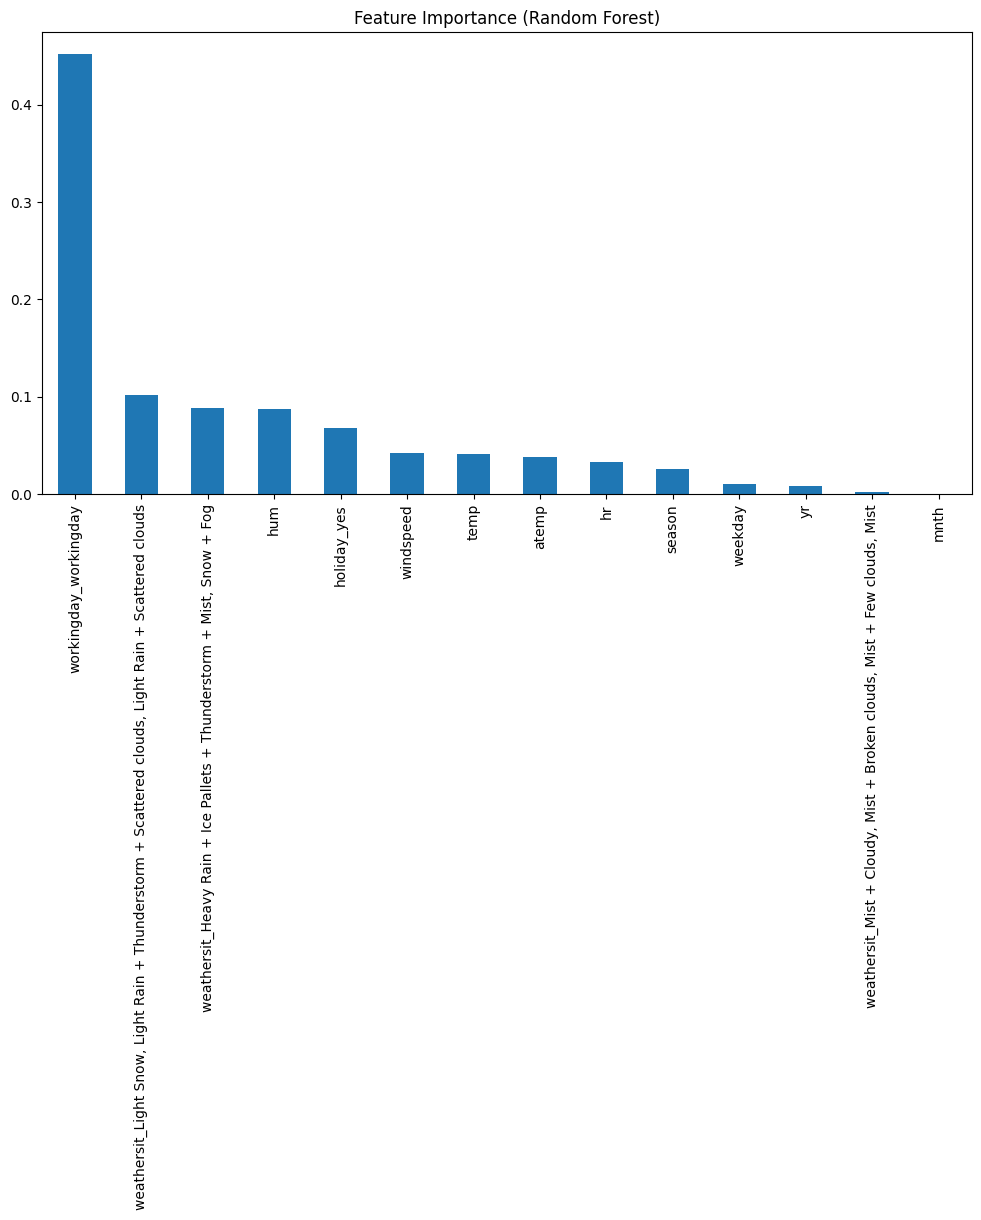

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

# Use the best estimator from GridSearchCV
best_pipe = grid.best_estimator_

# Step 1: Get feature names from trf1 (ColumnTransformer)
# OneHotEncoder produces multiple output columns
ohe_feature_names = best_pipe.named_steps['trf1'].transformers_[0][1].get_feature_names_out()

# Combine all transformed features: OneHotEncoder + OrdinalEncoder + numerical passthrough
# trf1 has: [('ohe', OneHotEncoder, [4,6,7]), ('ord', OrdinalEncoder, [0,2,5])]
# remainder='passthrough' applies to [1,3,8,9,10,11]

# Get all feature names in the correct order
# Extract raw feature names
raw_feature_names = X_train.columns.tolist()

# Order in ColumnTransformer:
# OneHot: 4,6,7 -> ['holiday', 'weathersit', 'workingday']
# Ordinal: 0,2,5 -> ['season', 'mnth', 'weekday']
# Passthrough: 1,3,8,9,10,11 -> ['yr', 'hr', 'temp', 'atemp', 'hum', 'windspeed']

ordinal_cols = ['season', 'mnth', 'weekday']
passthrough_cols = ['yr', 'hr', 'temp', 'atemp', 'hum', 'windspeed']

# Combine all feature names
feature_names = list(ohe_feature_names) + ordinal_cols + passthrough_cols

# Step 2: Get feature importances from the best model
importances = best_pipe.named_steps['trf3'].feature_importances_

# Step 3: Plot feature importances
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
feat_imp.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()
